<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=24px>
                    <b>Buildings vs Forest
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

# IMPORT THE LIBRARIES

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.7.0


# DEFINE ARCHITECTURE OF THE CNN MODEL

In [3]:
# create CNN Model

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(514))
        model.add(Dropout(0.2))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Dropout(0.2))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [4]:
EPOCHS = 25 # declaring number of epochs
INIT_LR = 1e-3 # setting the initial learning rate
BS = 32# declaring the batch size

# LOADING THE DATA

In [5]:
DATASET = "dataset"  # this folde must contain three subfolder with images
MODEL = "Scene.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [6]:
# import patoolib
# patoolib.extract_archive("dataset.rar")

In [7]:
# patoolib.extract_archive("test_examples.rar")

In [8]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('dataset')))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        

        if label == "Buildings":
            label = 0
        elif label == "Forest":
            label = 1
        elif label == "Sea":
            label = 2

        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/1326 [00:00<?, ?it/s]

In [9]:
# checking out shape of images
data[0].shape

(28, 28, 3)

In [10]:
# normalizing the pixel value and converting it into a numpy array
data = np.array(data, dtype="float") / 255.0
# converting labels list to an array
labels = np.array(labels)

In [11]:
labels

array([0, 1, 0, ..., 0, 0, 2])

# DATA PARTITIONING

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [13]:
trainX.shape

(994, 28, 28, 3)

In [14]:
trainY.shape

(994,)

In [15]:
# convert target to one-hot vector
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [16]:
trainY[0]

array([1., 0., 0.], dtype=float32)

# Data Preprocessing (Augumentation)

In [17]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

# TRAINING THE MODEL

In [18]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


2022-02-03 17:32:25.832393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ec2-user/.local/lib/python3.7/site-packages/cv2/../../lib64:
2022-02-03 17:32:25.833764: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 17:32:25.833802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-26-0-184.ap-south-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-02-03 17:32:25.834075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        1520      
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                    

In [20]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/25
31/31 [==============================] - 4s 104ms/step - loss: 0.9085 - accuracy: 0.5541 - val_loss: 0.7933 - val_accuracy: 0.5964
Epoch 2/25
31/31 [==============================] - 3s 95ms/step - loss: 0.8053 - accuracy: 0.5904 - val_loss: 0.6861 - val_accuracy: 0.6265
Epoch 3/25
31/31 [==============================] - 3s 96ms/step - loss: 0.7078 - accuracy: 0.6767 - val_loss: 0.7086 - val_accuracy: 0.6355
Epoch 4/25
31/31 [==============================] - 3s 96ms/step - loss: 0.6992 - accuracy: 0.6726 - val_loss: 0.5366 - val_accuracy: 0.7801
Epoch 5/25
31/31 [==============================] - 3s 95ms/step - loss: 0.6351 - accuracy: 0.7380 - val_loss: 0.6750 - val_accuracy: 0.6506
Epoch 6/25
31/31 [==============================] - 3s 94ms/step - loss: 0.6879 - accuracy: 0.7100 - val_loss: 0.5867 - val_accuracy: 0.7861
Epoch 7/25
31/31 [==============================] - 3s 94ms/step - loss: 0.6482 - accuracy: 0.7193 - val_loss: 0.4863 - val_ac

# EVALUATING THE MODEL

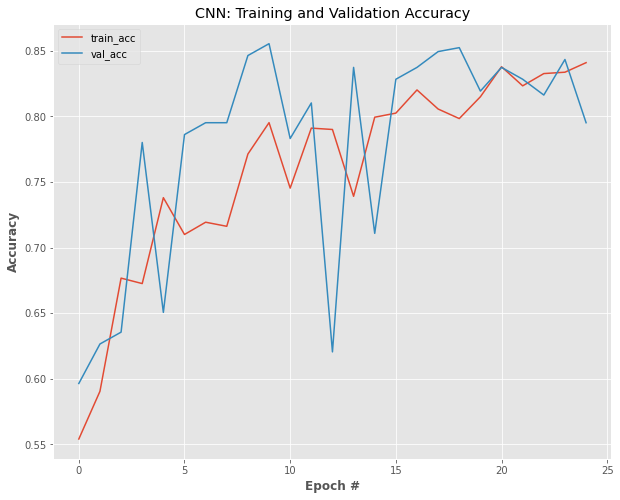

In [21]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

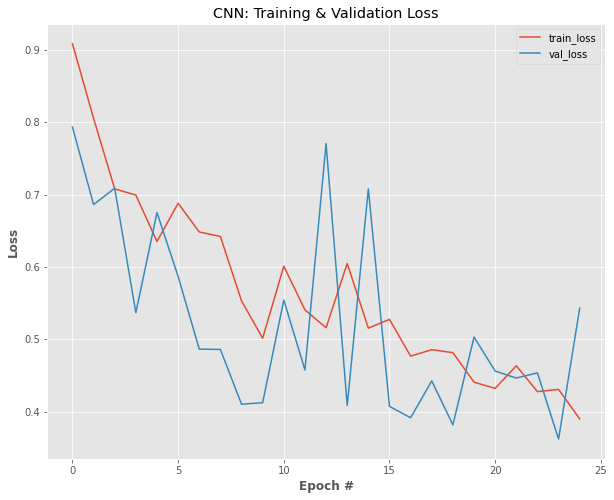

In [22]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# PREDICTING ON TEST DATA

In [23]:
#import necessary libraries
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# function to display image
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

[INFO] loading network and...


  0%|          | 0/28 [00:00<?, ?it/s]

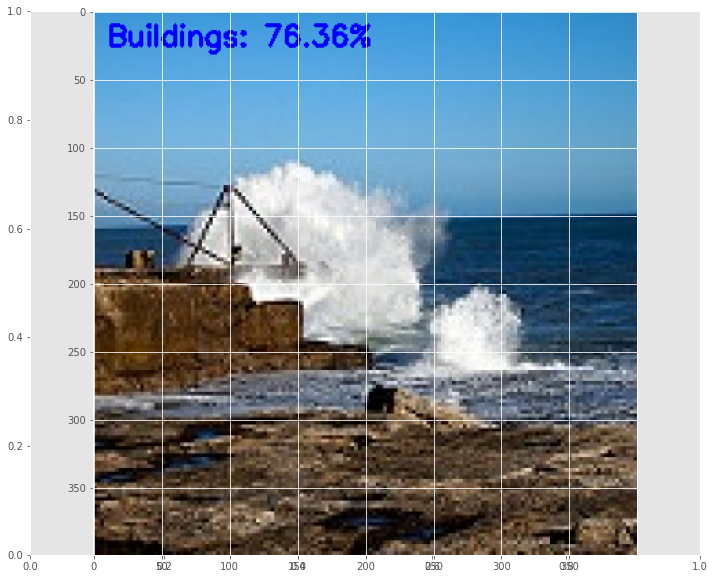

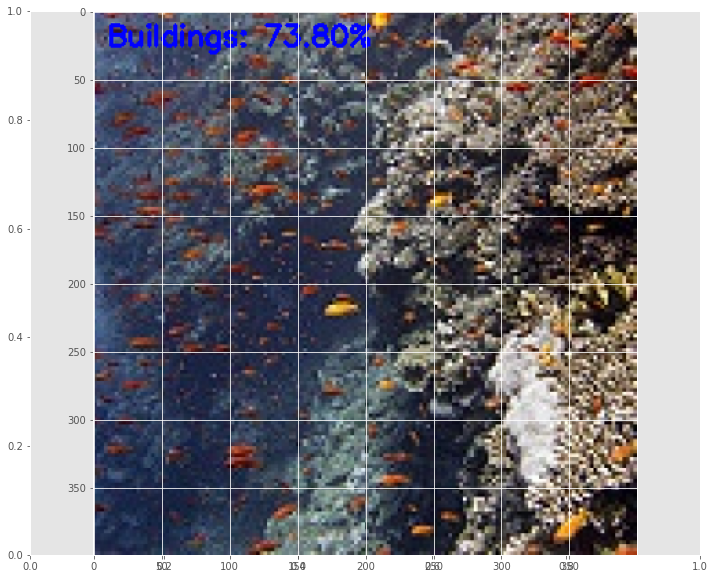

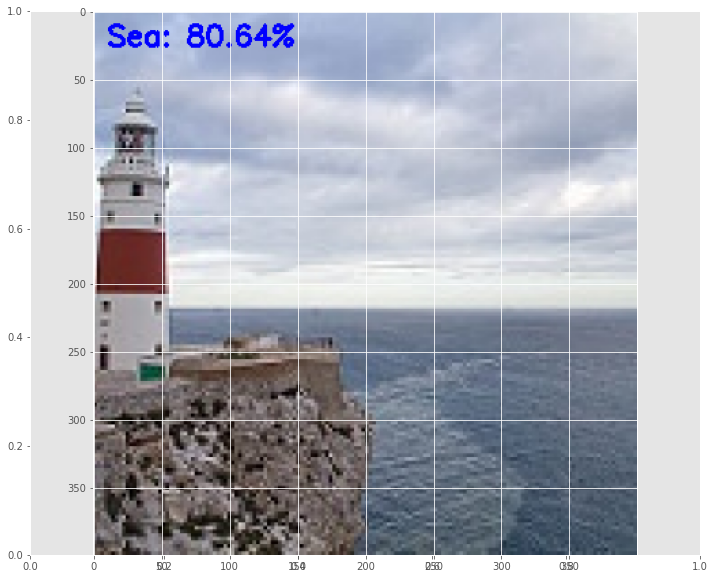

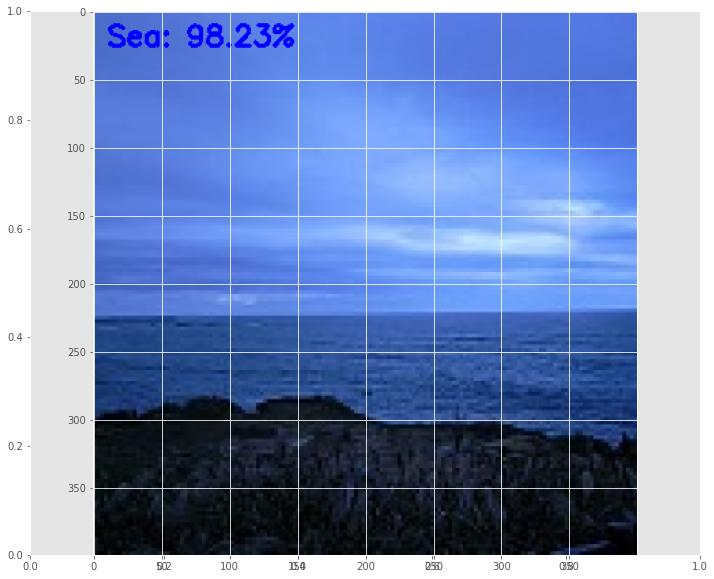

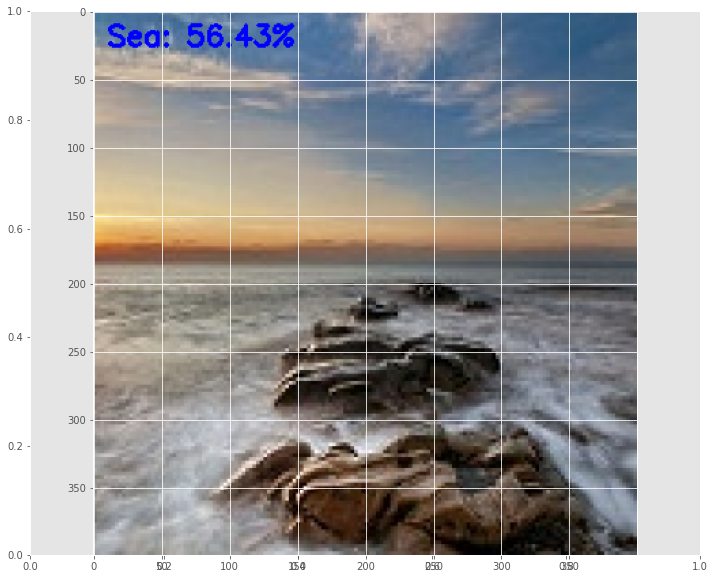

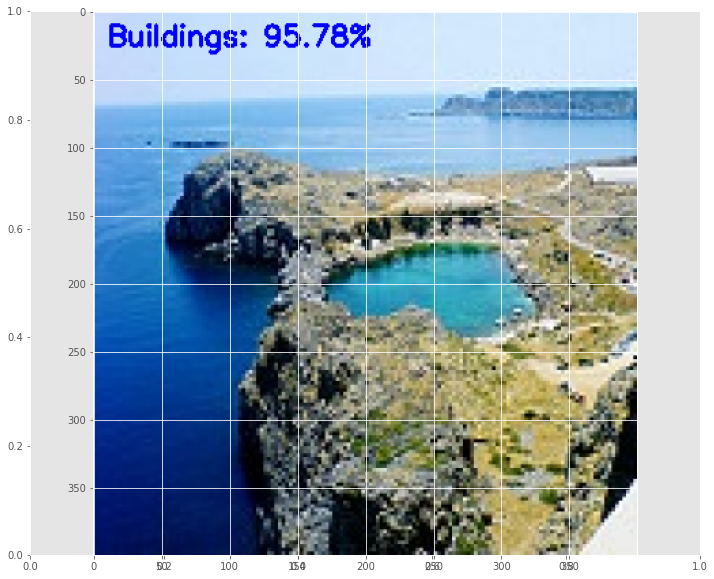

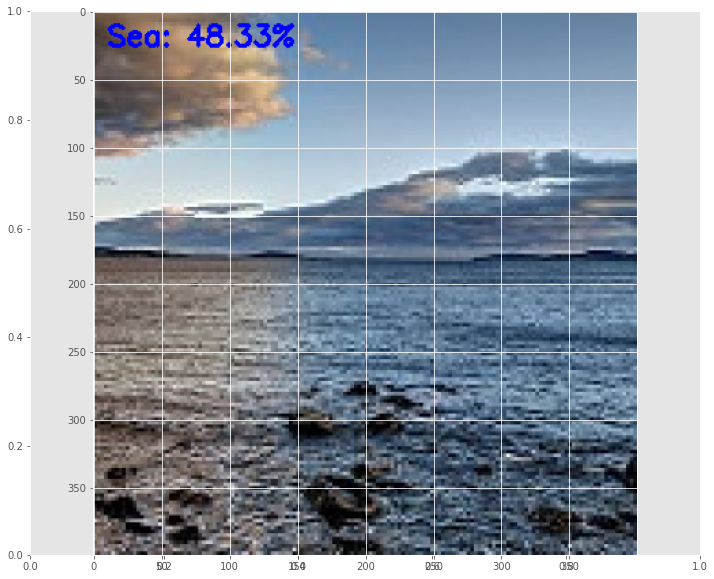

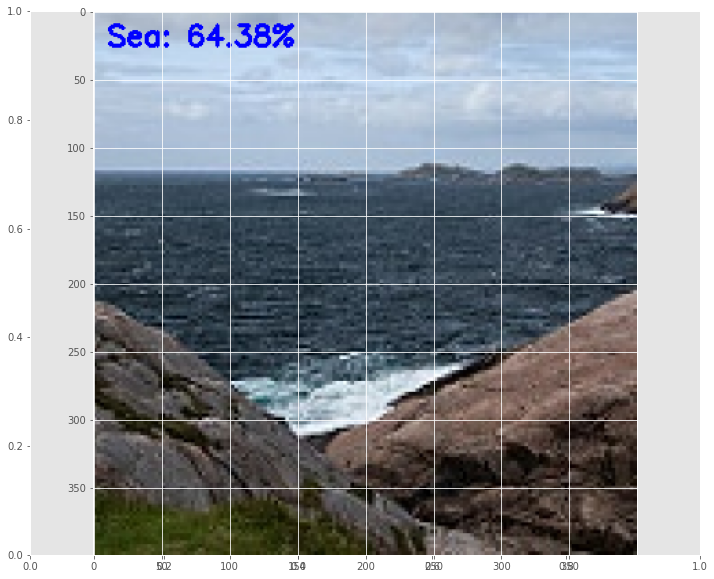

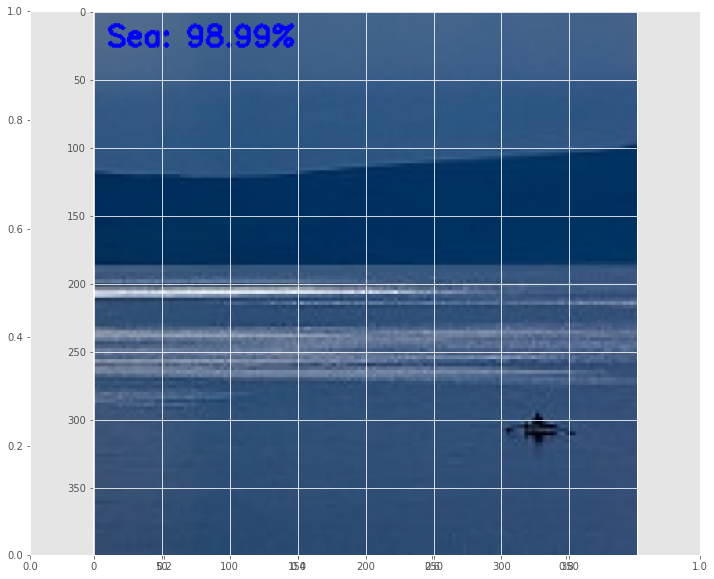

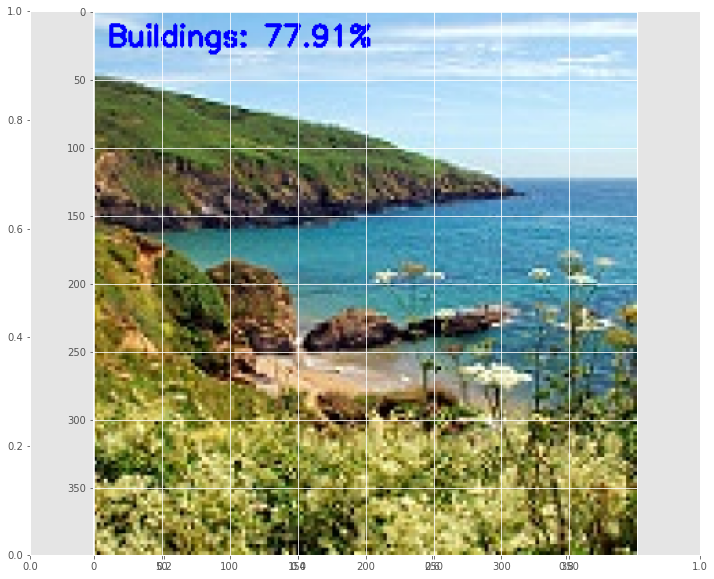

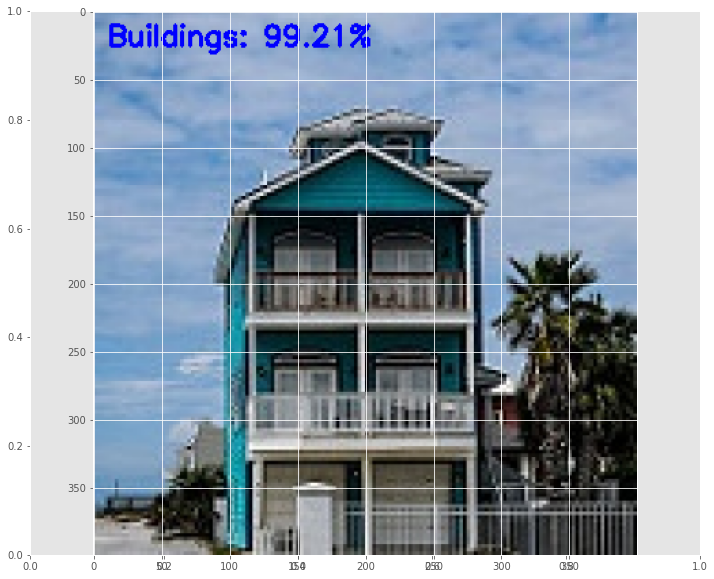

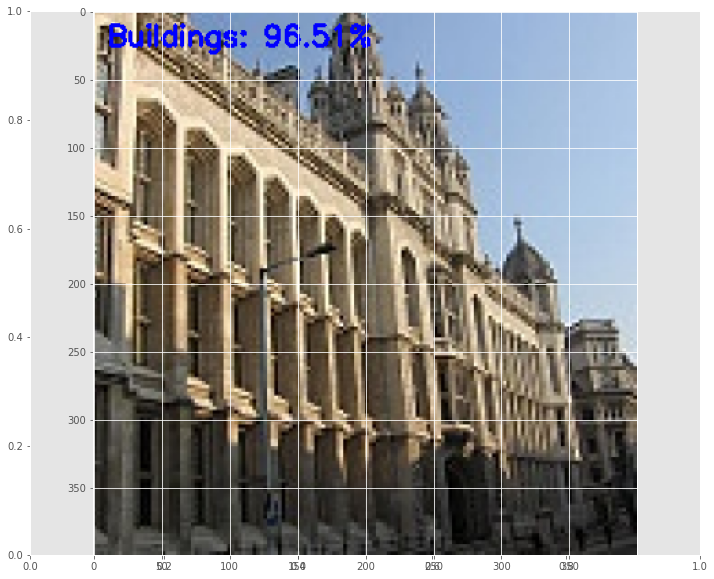

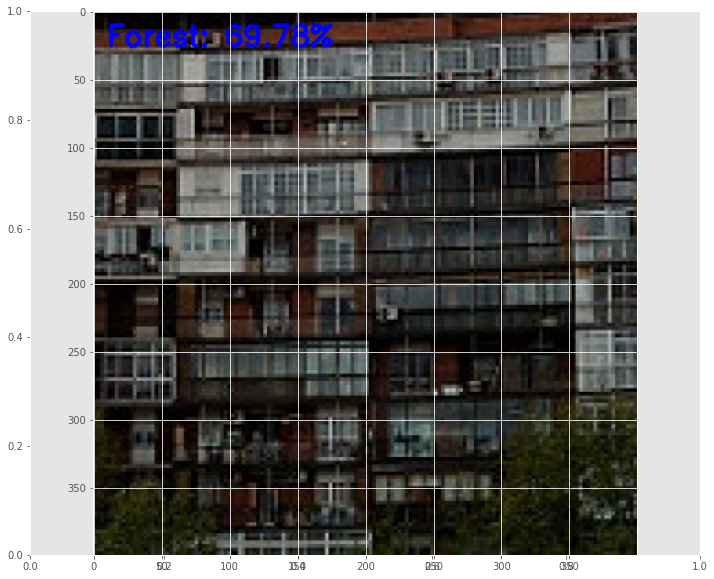

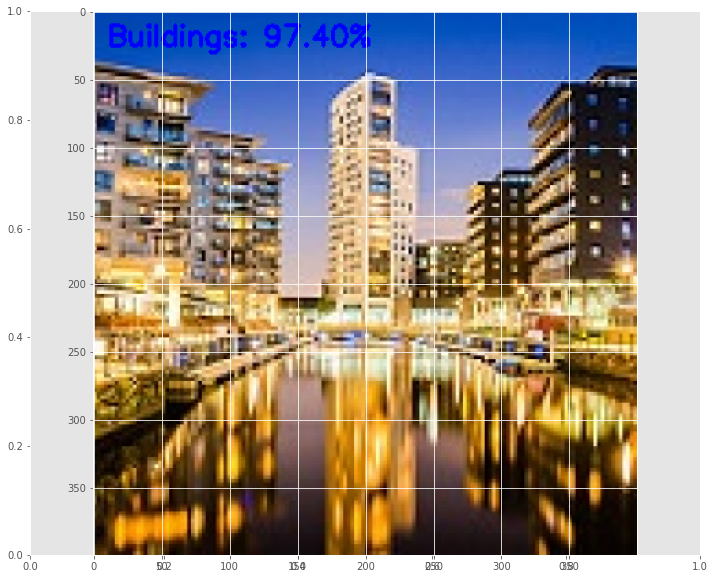

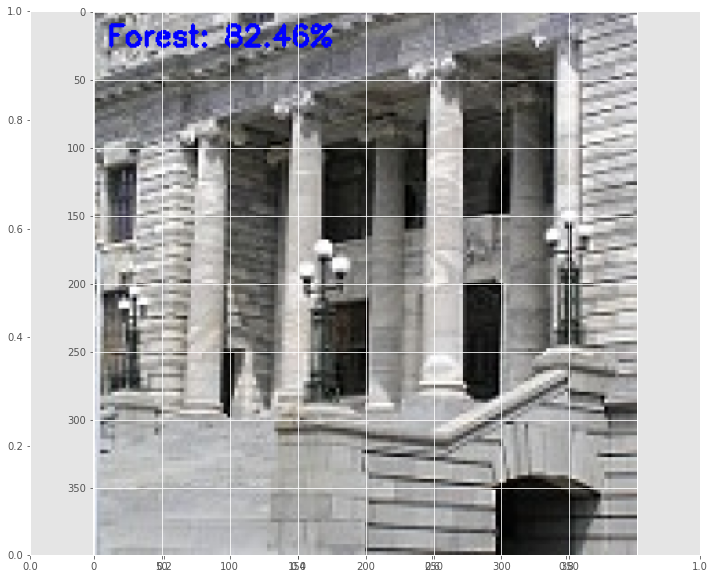

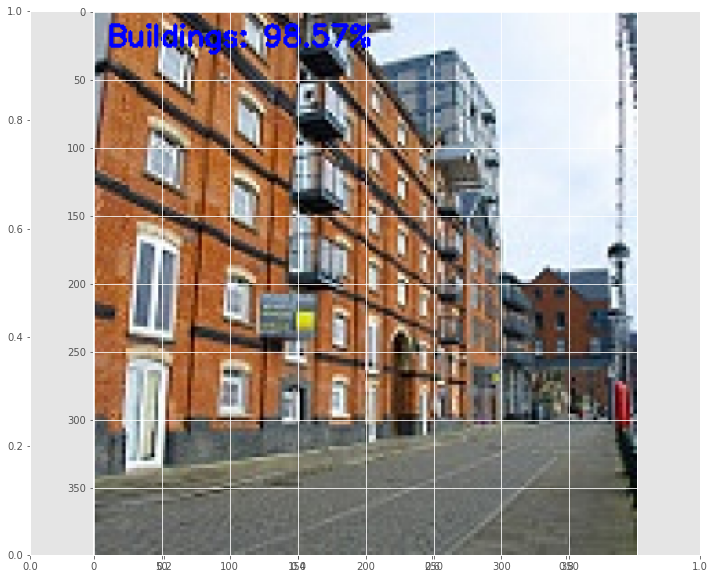

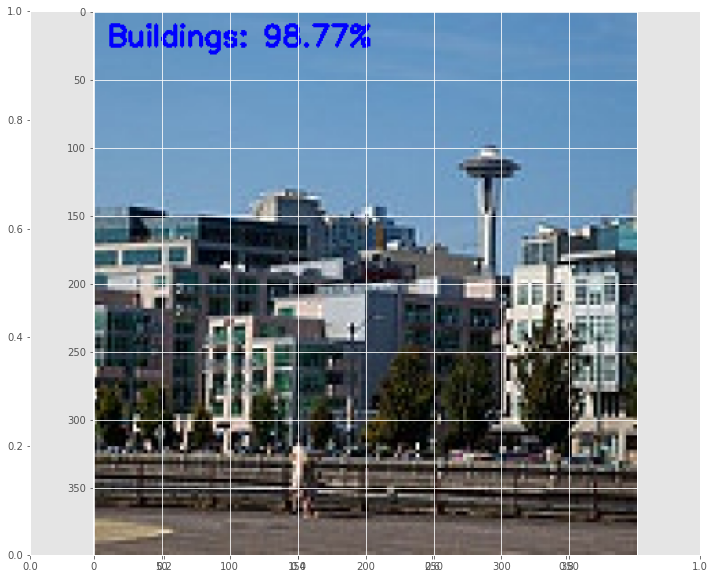

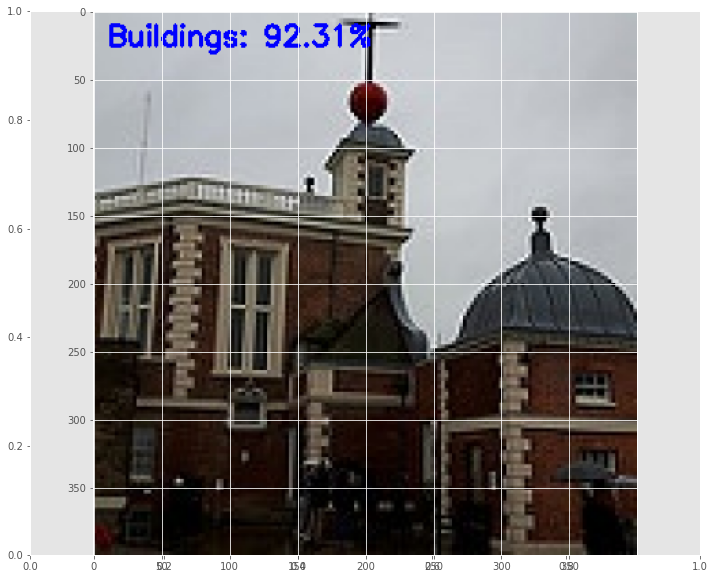

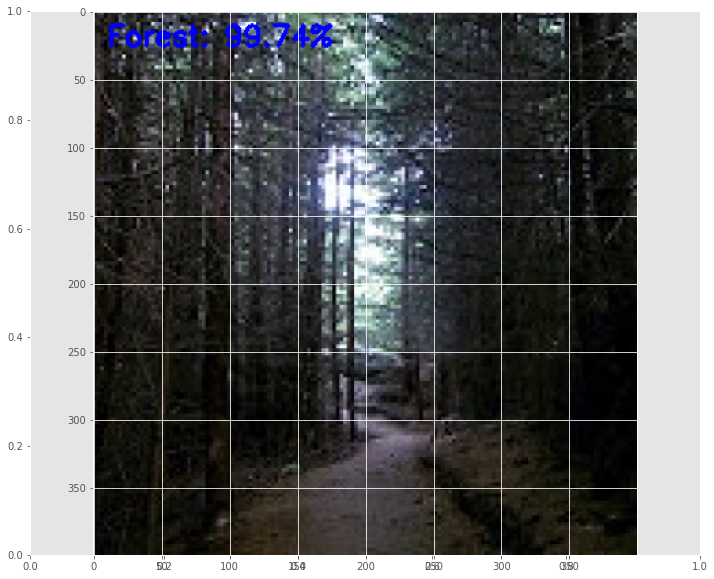

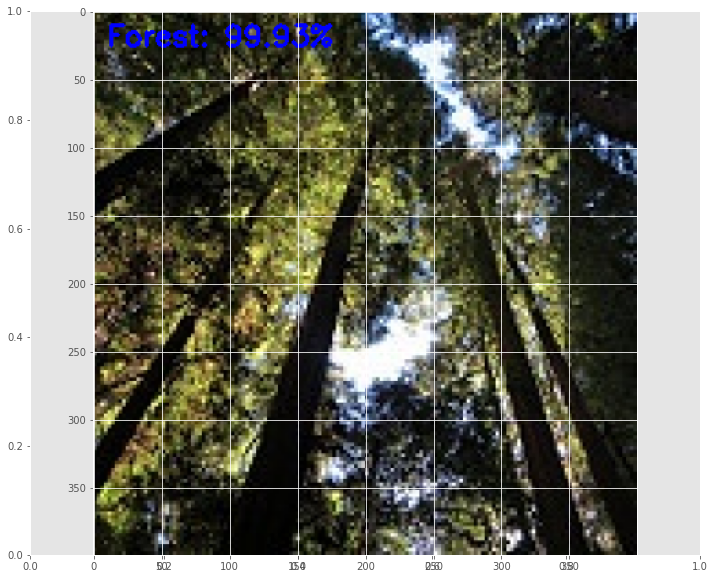

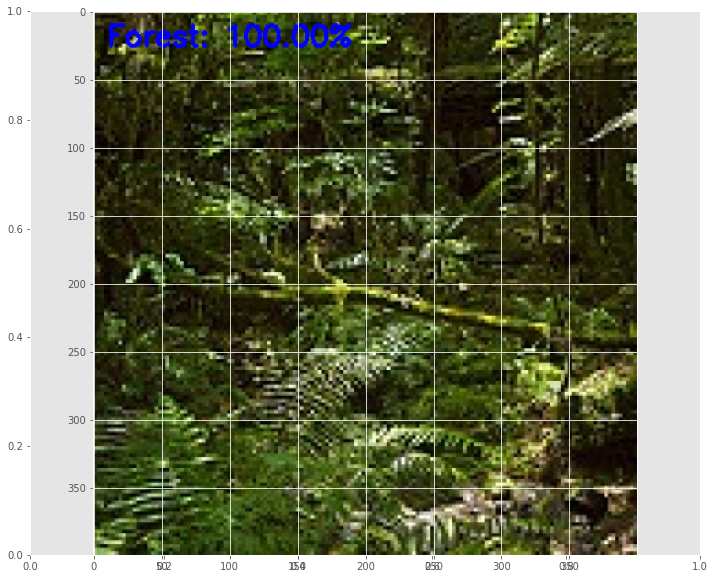

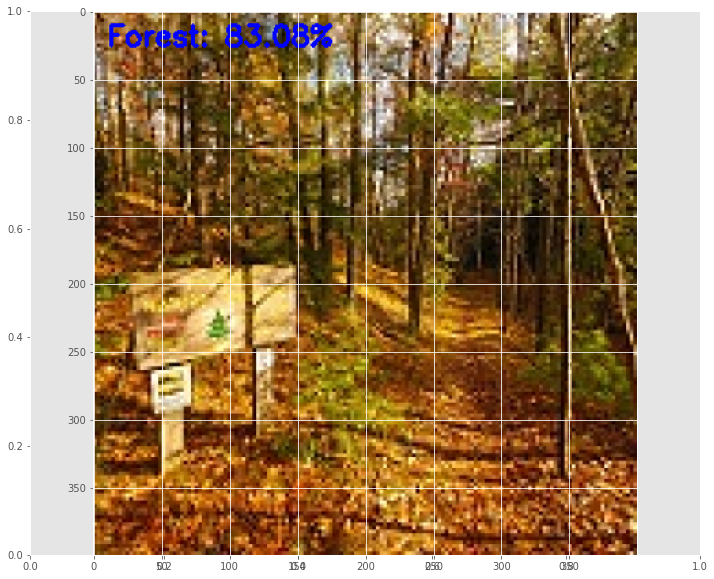

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Buildings", "Forest", "Sea"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf = model.predict(image)[0]

        # build the label
        label = all_class[np.argmax(prd_conf)]
        proba = prd_conf[np.argmax(prd_conf)]

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)
        
        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)
        
        pbar.update(1)
